# Variational Autoencoder 

![대체 텍스트](https://drive.google.com/uc?id=1OCoK4me3T3EcaEm6H-MobpVG45LrNRrh)

## TensorFlow 및 기타 라이브러리 가져오기

In [0]:
import numpy as np
import itertools as it
import pandas as pd
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
np.random.seed(2018)
tf.set_random_seed(2018)

## MNIST 데이터 셋 로드

In [0]:
# Load the MNIST data
mnist = input_data.read_data_sets('MNIST_data', one_hot=None)
X_train, X_test = mnist.train.images, mnist.test.images
print (X_train.shape, X_test.shape)
labels_train = mnist.train.labels
n_samples = int(mnist.train.num_examples)

W0826 11:14:36.130021 139788824717184 deprecation.py:323] From <ipython-input-2-c4a2d45579c9>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0826 11:14:36.131523 139788824717184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0826 11:14:36.132429 139788824717184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0826 11:14:36.383922 139788824717184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0826 11:14:36.426762 139788824717184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784) (10000, 784)


## Variational Autoencoder Class 생성

![대체 텍스트](https://drive.google.com/uc?id=1iNNT4PBS3dUeJ4ZYPmqWaU_7-ZUJRYyg)

In [0]:
class VariationalAutoencoder(object):
    # 초기변수 정의
    def __init__(self, n_layers=[784, 500, 500, 2], activefunction=tf.nn.softplus, learning_rate=0.001, batch_size=100, graph = tf.Graph()):
        
        # 입력과 출력 변수 갯수
        self.n_layers = n_layers
        # activefunction: 비선형 활성화 함수 Softplus 사용, Range: (0, ∞), 매끄럽게 만든 ReLU 함수라고 할 수 있음. 함수의 식은 log(exp(x) + 1)
        # activefunction2: 비선형 활성화 함수 sigmoid 사용, Range:(0,1)
        self.activefunction = activefunction
        self.activefunction2 = tf.nn.sigmoid
        
        # hyperparameters 정의
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # 텐서플로우 계산 그래프 함수 정의
        self.graph = graph
        
        # 그래프 생성
        with self.graph.as_default():
            # 손실에 대한 최적화 알고리즘 정의(AdamOptimizer사용)
            optimizer = tf.train.AdamOptimizer(learning_rate)
            # 변수 초기화 함수 정의(모델 실행전 모든 변수 초기화) 
            network_weights = self._initialize_weights()
            self.weights = network_weights
            
            # VAE 모델 생성
            self.x = tf.placeholder(tf.float32, [None, self.n_layers[0]])
            x = self.x        
            
            # Encoder network 생성(=inference Modell)
            #  Gaussian MLP as encoder
            self.hidden_encode = []
            encoder_h1 = self.activefunction(
                tf.add(tf.matmul(x, self.weights['encode'][0]['w']),
                       self.weights['encode'][0]['b']))
            encoder_h2 = self.activefunction(
                tf.add(tf.matmul(encoder_h1, self.weights['encode'][1]['w']),
                       self.weights['encode'][1]['b']))
                        
            # Encoder network의 마지막 hidden layer의 평균(mean)과 표준편차(log_sigma) 정의  
            # sigma(표준편차)의 경우 항상 0보다 크거나 같아야하는데 마지막 hidden layer 연산을 한 encoder 층을 지나면 -값이 될 수 있기 때문에 이 값을 sigma로 보지 않고 log sigma라고 봄
            
            self.mean = tf.add(
                tf.matmul(encoder_h2, self.weights['mean']['w']), 
                self.weights['mean']['b'])
            
            self.log_sigma = tf.add(
                tf.matmul(encoder_h2, self.weights['log_sigma']['w']), 
                self.weights['log_sigma']['b'])
            
            # Reparameterization Trick사용을 위해 Gussian(normal)분포에서 랜덤변수(sample) ε추출 
            eps = tf.random_normal(tf.stack([tf.shape(self.x)[0], self.n_layers[-1]]), 0, 1, dtype = tf.float32)            
            
            # z 정의
            self.z = tf.add(self.mean, tf.multiply(tf.exp(self.log_sigma), eps))
            z = self.z     
            
            # Decoder network 생성(=generator model)
            # Bernoulli MLP as decoder
            self.hidden_decoder = []  
            
            decoder_h1 = self.activefunction(
                    tf.add(tf.matmul(z, self.weights['decode'][0]['w']),
                        self.weights['decode'][0]['b']))
            
            decoder_h2 = self.activefunction(
                    tf.add(tf.matmul(decoder_h1, self.weights['decode'][1]['w']),
                        self.weights['decode'][1]['b']))
            
            # Decoder의 마지막 layer를 x_hat로 정의(x_hat = reconstruction x)
            #  x_hat은 베르누이 분포를 따르도록 함. 데이터 분포의 평균을 (0,1)범위로 출력
            self.x_hat = self.activefunction2(
                    tf.add(tf.matmul(decoder_h2, self.weights['decode'][2]['w']),
                        self.weights['decode'][2]['b']))  
            
            # Loss fuction 정의            
            # (1) Marginal_likelihood(Reconstruct Error) : Cross-entropy 
            #   ln(0)=-Infinity을 피하기 위해 1e-10 추가
            self.marginal_likelihood =  tf.reduce_sum(self.x * tf.log(1e-10 + self.x_hat) + (1-self.x) * tf.log(1e-10 + 1 - self.x_hat),1)
            
            # (2) KL divergence(Regularization,latent_loss)
            self.KL_divergence = 0.5 * tf.reduce_sum(tf.square(self.mean)
                                            + tf.exp(self.log_sigma)- 2*self.log_sigma -1, 1)
            # (3) ELBO(VAE Loss function)
            self.ELBO = tf.reduce_mean(self.marginal_likelihood - self.KL_divergence) # max ELBO
            self.optimizer = optimizer.minimize(-self.ELBO) # min(-ELBO)
            
            # Create a saver(saver는 모든 변수를 각자의 이름으로 저장 및 복원)
            self.saver = tf.train.Saver()
            # 세션 실행전 변수 초기화 함수 정의
            self.init = tf.global_variables_initializer()
        
        # 세션 정의
        self.sess = tf.Session(graph=self.graph)
        # 세션 실행(변수 초기화)
        self.sess.run(self.init)
        
    # VAE 모델 초기화 함수 정의 
    def _initialize_weights(self):
        all_weights = dict()
        initializer = tf.contrib.layers.xavier_initializer()
        # Encoding network weights
        Encoder_weights = []
        for layer in range(len(self.n_layers)-2): # 4-2=2: 마지막 제외한 hidden layer 갯수
            
            w = tf.Variable(
                initializer((self.n_layers[layer], self.n_layers[layer + 1]),
                            dtype=tf.float32))
            
            b = tf.Variable(
                tf.zeros([self.n_layers[layer + 1]], dtype=tf.float32))
            Encoder_weights.append({'w': w, 'b': b})
            
        # Z(Latent variable)layer weights
        w = tf.Variable(
            initializer((self.n_layers[-2], self.n_layers[-1]),
                        dtype=tf.float32))
       
        b = tf.Variable(
            tf.zeros([self.n_layers[-1]], dtype=tf.float32))
        all_weights['mean'] = {'w': w, 'b': b}
       
        w = tf.Variable(
            initializer((self.n_layers[-2], self.n_layers[-1]),
                        dtype=tf.float32))
       
        b = tf.Variable(
            tf.zeros([self.n_layers[-1]], dtype=tf.float32))
      
        all_weights['log_sigma'] = {'w': w, 'b': b}
      
        # Decoder network weights
        Decoder_weights = []
        for layer in range(len(self.n_layers)-1, 0, -1): # range(start, limit, delta) => [3,2,1,0]
            w = tf.Variable(
                initializer((self.n_layers[layer], self.n_layers[layer - 1]),
                            dtype=tf.float32))
           
            b = tf.Variable(
                tf.zeros([self.n_layers[layer - 1]], dtype=tf.float32))
          
            Decoder_weights.append({'w': w, 'b': b})
        all_weights['encode'] = Encoder_weights
        all_weights['decode'] = Decoder_weights
        return all_weights
   
    # 미니배치 모델을 훈련시킴(cost 반환) 
    def fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.ELBO),feed_dict={self.x: X})
        return -cost
    
    # Transform data by mapping it into the latent space.
    def transform(self, X):
        return self.sess.run(self.mean, feed_dict={self.x: X})
    
    # Generate data by sampling from latent space.
    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.randn(1, self.n_layers[-1])
        # Note: This maps to mean of distribution, we could alternatively
        #  sample from Gaussian distribution    
        return self.sess.run(self.x_hat, feed_dict={self.z: hidden}) # x_hat: Decoder의 마지막 layer (x_hat = reconstruction x)
      
    # Use VAE to reconstruct given data.
    def reconstruct(self, X):
        return self.sess.run(self.x_hat, feed_dict={self.x: X}) # x_hat: Decoder의 마지막 layer (x_hat = reconstruction x)

    def save(self, path):
        '''To save trained model and its params.
        '''
        save_path = self.saver.save(self.sess, 
            os.path.join(path, 'model.ckpt'))
        # save parameters of the model
        params = {'n_layers': self.n_layers, 'learning_rate': self.learning_rate}
        json.dump(params, 
            open(os.path.join(path, 'model_params.json'), 'w'))
        return save_path
    
    # 실행 그래프 저장
    def _restore(self, path):
        with self.graph.as_default():
            self.saver.restore(self.sess, path)

    @classmethod
    # To restore a saved model
    def load(cls, path):
        # load params of the model
        params = json.load(open(os.path.join(path, 'model_params.json'), 'r'))
        # init an instance of this class
        estimator = cls(**params)
        estimator._restore(os.path.join(path, 'model.ckpt'))
        return estimator

# Train함수 생성 및 VAE 모델 훈련
###2개의 Latent Space를 가진 VAE모델을 훈련시킵니다.

In [0]:
# Train 함수 정의
def train(learning_rate=0.001, batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(learning_rate=learning_rate,batch_size=batch_size)
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # 모든 배치들에 대하여 최적화 수행
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size) # 배치사이즈에 맞게 x, y값 생성
            
            # Fit(opt, cost) training using batch data
            cost = vae.fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Epoch당 로그 표시
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae
  
vae2d = train(training_epochs=30)


Epoch: 0001 cost= 189.414562184
Epoch: 0006 cost= 154.178087907
Epoch: 0011 cost= 149.330469444
Epoch: 0016 cost= 146.369472434
Epoch: 0021 cost= 144.558603405
Epoch: 0026 cost= 143.385445668


## Reconstruction 결과확인
### x와 x'를 출력하여 얼마나 잘 복원됐는지 확인합니다.  

(100, 784)


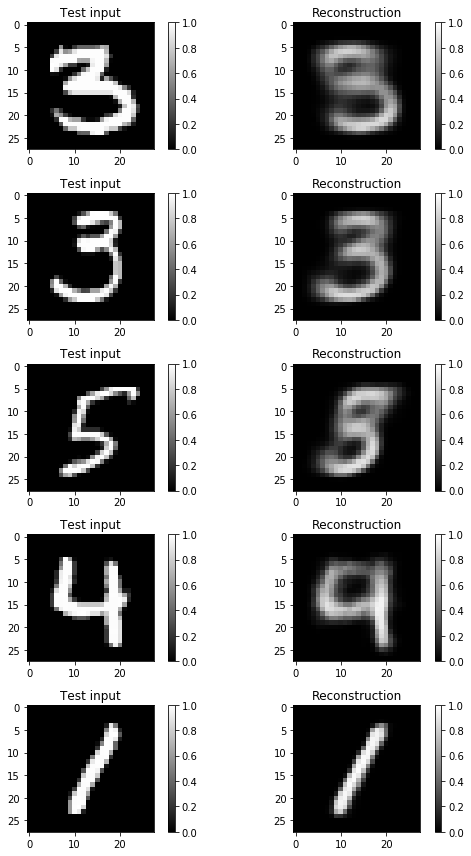

In [0]:
# 입력MNIST 이미지와 복원된 MNIST 이미지를 8x12 figsize로 보여주는 plot 함수 정의
x_sample = mnist.test.next_batch(100)[0] #[0]:x값만 출력 [1]:y값
x_reconstruct = vae2d.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Visualization
### 2D Latent Space 위치해 있는 데이터의 Manifold를 출력합니다. 

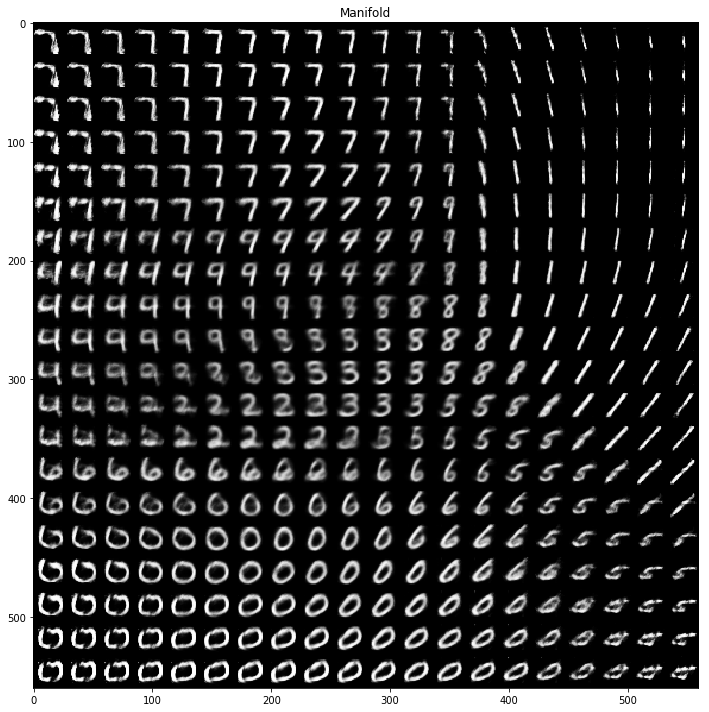

In [0]:
# 훈련된 모델의 MNIST Manifold를 20x20 Grid 로 보여주는 plot 정의
nx = ny =20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        l = np.array([[xi, yi]]*vae2d.batch_size)
        x_hat = vae2d.generate(l)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

plt.figure(figsize=(10, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.title("Manifold")
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

### Latent Space에서 데이터 Interpolation을 수행합니다.





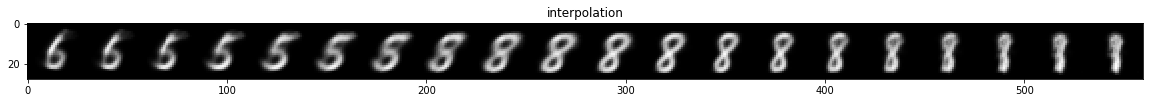

In [0]:
n=20
alpha = np.linspace(-1, 1,n)

canvas = np.empty((28, 28*n))
for i, yi in enumerate(alpha):
    for j, xi in enumerate(alpha):
        l = np.array([[xi, yi]])
        x_hat = vae2d.generate(l)
        canvas[:, i*28: (i+1)*28] = x_hat[0].reshape(28, 28)
fig, ax = plt.subplots(figsize=(20,20))             
plt.title("interpolation")
ax.imshow(canvas, cmap="gray")


In [0]:
# Interpolation between two classes a and b.   
#  Z: np.array of the latent space with shape: (n_samples, latent_dim)
#  labels: array of class labels (n_samples, ) 
def interpolate_from_a_to_b(Z, labels, generator, a, b, alpha , figsize=(12,5)):
    
    # Find the centroids of the classes a, b
    z_a_avg = Z[labels == a].mean(axis=0)
    z_b_avg = Z[labels == b].mean(axis=0)
    
    # Pick the medoid for class a for interpolation
    z_a_med = np.median(Z[labels == a], axis=0)
    
    # The interpolation vector pointing from b -> a
    z_b2a =  z_b_avg - z_a_avg 

    x_gens = []
    
    for alpha in alphas:
        z_interp = z_a_med + alpha * z_b2a
        x_gens.append(generator.generate(z_interp.reshape(1, -1)))

    n = len(x_gens)
    
    #MNIST 이미지 figsize=(12,5) 출력
    canvas = np.empty((28, 28*n))
    for i, x in enumerate(x_gens):
        # scale to (0, 1)
        x = preprocessing.minmax_scale(x.T).T
        canvas[:, i*28: (i+1)*28] = x[0].reshape(28, 28)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(canvas, cmap="gray")
    ax.set_axis_off()
    
    return ax, x_gens
  
#Interpolation 실행  
a,b = 6,8
Z_test_vae2d = vae2d.transform(X_test)
alphas = np.linspace(-10,10,20)
ax, x_gens = interpolate_from_a_to_b(Z_test_vae2d, mnist.test.labels, vae2d,  
                                    a,b, alphas)
ax.set_title('VAE 20d')

## Reference
-------
*   https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
*   https://nbviewer.jupyter.org/github/wangz10/Generative-Models/blob/master/Main.ipynb?source=post_page


## Colab link(GPU실행)

*  [https://colab.research.google.com/drive/1Vd1KYBGO7umV697ROT7ogwv8heZ1PTsg?authuser=3#scrollTo=_FmztqZElx0Z&uniqifier=4&forceEdit=true&offline=true&sandboxMode=true](https://colab.research.google.com/drive/1Vd1KYBGO7umV697ROT7ogwv8heZ1PTsg?authuser=3#scrollTo=_FmztqZElx0Z&uniqifier=4&forceEdit=true&offline=true&sandboxMode=true)






